In [1]:
%matplotlib inline
import pandas as pd
from pathlib import Path
import json
from matplotlib import pyplot as plt
import seaborn as sns

def smooth(arr, window):
    return pd.Series(arr).rolling(window, min_periods=1).mean().values

In [2]:
path = Path('../runs/')
runs = []
for p in path.glob("*/config.json"):
    with open(p) as data_file:    
        config = json.load(data_file)
    with open(p.parent / 'metrics.json') as data_file:    
        metrics = json.load(data_file)
    with open(p.parent / 'run.json') as data_file:    
        meta = json.load(data_file)
    
    runs.append({**metrics, **config, **meta})

runs = pd.DataFrame(runs)

In [8]:
runs.iloc[0]

K                                                                           1
S                                                                           5
architecture                                                       non_linear
artifacts                                                                  []
batch_size                                                               1000
checkpoint                                                              False
checkpoint_frequency                                                        2
command                                                            experiment
cuda                                                                     True
data_dir                                                              ./data/
data_name                                                            data.pkl
epochs                                                                     10
experiment                  {'base_dir': '/ubc/cs/research/fwood

loss = vae, S = 10 has multiple runs, using least recent
loss = vae, S = 50 has multiple runs, using least recent
loss = iwae, S = 2 missing
loss = iwae, S = 5 missing


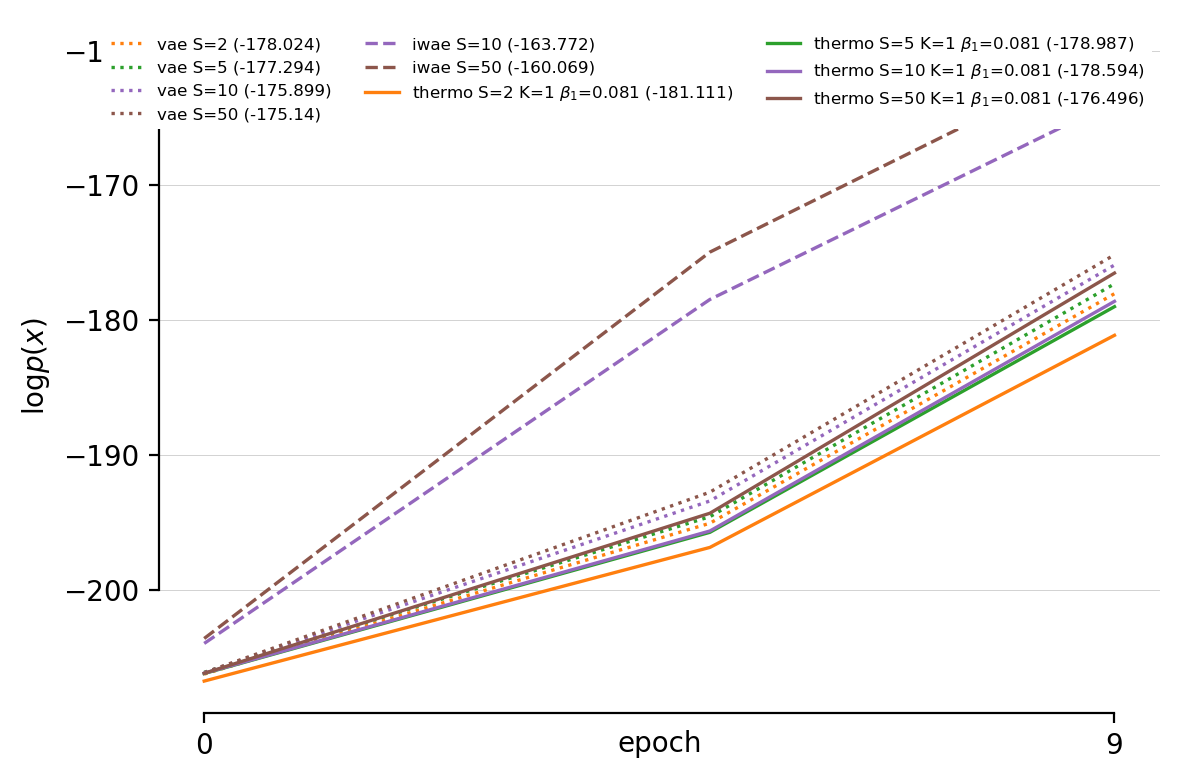

In [9]:
fig, ax1 = plt.subplots(1, 1, dpi=200, figsize=(6, 4))

linestyle = {
    "thermo":"solid",
    "vae":":",
    "iwae":"--",
}


colors = {
    2: 'C1',
    5: 'C2',
    10: 'C4',
    50: 'C5'
}

for loss in ['vae', 'iwae', 'thermo']:
    for S in [2, 5, 10, 50]:
        filtered = runs.query("S==@S and loss==@loss")

        if filtered.shape[0] == 0:
            print("loss = {}, S = {} missing".format(loss, S))
            continue
        
        if filtered.shape[0] > 1:
            print("loss = {}, S = {} has multiple runs, using least recent".format(loss, S))
            filtered = filtered[filtered.start_time == filtered.start_time.min()]
        
        test_elbo = filtered['test.elbo'].values[0]
        
        if pd.isna(test_elbo):
            print("loss = {}, S = {} has nan test.elbo")
            continue

        K = filtered.K.iloc[0]
        log_beta_min = filtered.log_beta_min.iloc[0]
        
        results = test_elbo['values']
        steps   = test_elbo['steps']
        values  = smooth(results, 5)

        if loss == 'thermo':
            label = r'{} S={} K={} $\beta_1$={} ({})'.format(loss, S, K, round(10**log_beta_min, 3), round(values[-1], 3))
        else:
            label = r'{} S={} ({})'.format(loss, S, round(values[-1], 3))


        ax1.plot(steps,
                 values,
                 color = colors[S],
                 linestyle = linestyle[loss],
                 linewidth = 1.2,
                 label = label)
                    
        
# ax1.set_ylim(-92, -83)
ax1.grid(True, axis='y', linewidth=0.2)

leg = ax1.legend(fontsize=6, ncol=3, frameon=True, framealpha=1, facecolor='white', loc='upper right')
leg.get_frame().set_linewidth(0.0)

ax1.set_ylabel(r'$\log p(x)$')
ax1.set_xlabel('epoch')
ax1.xaxis.set_label_coords(0.5, -0.025)

xmax = steps[-1]

ax1.set_xticks([0, xmax])
ax1.set_xticklabels([0, str(xmax)])
sns.despine(ax=ax1, trim=True)

fig.tight_layout()
plt.show()
# plot_dir = Path('../continuous_vae/plots')
# filename = plot_dir / "baseline.pdf" 
# fig.savefig(filename, bbox_inches='tight')
# print('saved to {}'.format(filename))


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=200, figsize=(6, 4))

linestyle = {
    "thermo":"solid",
    "vae":":",
    "iwae":"--",
}



colors = {
    2: 'C1',
    5: 'C2',
    10: 'C4',
    50: 'C5'
}


burnin = 0

for index, row in exps.sort_values("S").sort_values("loss", ascending=False).iterrows():
    model_variance = df.loc[index].loc['model.variance']['values'].values
    network_variance = df.loc[index].loc['network.variance']['values'].values

    model_variance = smooth(model_variance, 2)
    network_variance = smooth(network_variance, 2)
    
    steps = df.loc[index].loc['model.variance']['steps'].values

    method, S = row['loss'], row['S']

    alpha = 1.0
    
    val = '%.2e' % Decimal(model_variance.mean())
    label = r'{} {} ({})'.format(method, S, val, 5)
    
    ax1.plot(steps,
             model_variance,
             color = colors[S],
             alpha = alpha,
             linestyle = linestyle[method],
             linewidth = 1.2,
             label = label)

    val = '%.2e' % Decimal(network_variance.mean())
    label = r'{} {} ({})'.format(method, S, val, 5)
    
    ax2.plot(steps,
             network_variance,
             color = colors[S],
             alpha = alpha,
             linestyle = linestyle[method],
             linewidth = 1.2,
             label = label)


ax1.set_ylim(0, 0.016)
ax1.grid(True, axis='y', linewidth=0.2)

leg = ax1.legend(fontsize=6, ncol=3, frameon=True, framealpha=1, facecolor='white', loc='upper right')
leg.get_frame().set_linewidth(0.0)

ax1.set_ylabel(r"$\theta$-grad std")
ax1.set_xlabel('epoch')
ax1.xaxis.set_label_coords(0.5, -0.025)
ax1.set_xticks([0, 5000])
ax1.set_xticklabels([0, '5000'])
sns.despine(ax=ax1, trim=True)

ax2.set_ylim(0.00, 0.032)
ax2.grid(True, axis='y', linewidth=0.2)

leg = ax2.legend(fontsize=6, ncol=3, frameon=True, framealpha=1, facecolor='white', loc='upper right')
leg.get_frame().set_linewidth(0.0)

ax2.set_ylabel(r"$\phi$-grad std")
ax2.set_xlabel('epoch')
ax2.xaxis.set_label_coords(0.5, -0.025)
ax2.set_xticks([0, 5000])
ax2.set_xticklabels([0, '5000'])
sns.despine(ax=ax2, trim=True)

fig.tight_layout()

plot_dir = Path('../continuous_vae/plots')
filename = plot_dir / "grad_tvo.pdf" 
fig.savefig(filename, bbox_inches='tight')
print('saved to {}'.format(filename))
